# PV Performance Model Validation
###### Lelia Deville - SAND2023-11362O 

#### The purpose of this notebook is to validate the use of new or current PV performance models through multiple steps of analysis 

#### The model input data comes from the published results of the 2021 Blind Modeling Comparison. In the following notebook the data collected in S2 is used, which is from the Canadian Solar 275W system at Sandia National Labs in Albuquerque, NM from  Jan 2021 - Dec 2021. More information about the dataset can be found at the [DuraMAT Data Hub](https://datahub.duramat.org/dataset/pv-performance-modeling-data/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5) and the [published results of the 2021 Blind Modeling Comparison](https://onlinelibrary.wiley.com/doi/pdf/10.1002/pip.3729) 

#### To demonstrate the way this notebook should work, a pvlib-python model, specifically CEC, is used in place of a user defind model. To use this notebook for a custom model, simply replace the CEC model defined in _3: Run model to be validated or import model results_. If the model is run by an external program, it is also possible to import only the results to use in the validation and analysis. 

#### The notebook is segemented into 4 sections:

<li><b>1. Import data from DuraMAT</b></li>
<li><b>2. Define relevant system & meteo data</b></li>
<li><b>3. Run model to be validated or import model results</b></li>
<li><b>4. Compare model to measured results and other baseline models</b></li>

In [1]:
#import necessary packages and set default formatting for plots
import matplotlib as mpl #v. 3.7.2
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np #v. 1.24.3
import seaborn as sns #v 0.12.2
import pandas as pd #v. 2.0.3
import pvlib #v. 0.9.3
import pvanalytics #v 0.1.3
import sklearn.metrics #v. 1.3.0
import scipy #v. 1.11.1
from tabulate import tabulate #v. 0.8.10

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12
pd.options.mode.chained_assignment = None

## 1. Import data

This section imports the meteo and system data from the DuraMAT Datahub. For the purpose of accurate solar position calculations, the times are set to be labeled at the middle-of-hour. The data includes 2 filters: _bsrn pass_ and _SNL No Snow_. The baseline surface radiation network (BSRN) filter follows [version 2 quality control tests](https://epic.awi.de/id/eprint/30083/1/BSRN_recommended_QC_tests_V2.pdf) and the SNL No Snow filter removes any days with recorded snow fall or snow depth. Data is removed if either filter value is '0'. For the meteo data, any 0 values are replaced with NaNs so that statistical values, like mean, are not affected by these values. 

In [2]:
#read in data from duramat datahub directly
df = pd.read_excel(https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx,
                  sheet_name='S2'

#Reassigning the index so the timesteps are at the middle of the hour
df.index = pd.date_range(start='2021-01-01 00:30:00', end='2021-12-31 23:30:00', freq='H')
df.index = df.index.tz_localize('MST')

#apply the filters that are included in the data & replacing any 0 with nan so they dont affect error metrics
#dropping nans helps keep size down so operations run more quickly and smoothly
df = df.where((df['bsrn_pass'] == 1) & (df['SNL No Snow'] == 1) & (df['Measured DC power (W)'] > 1)).dropna()
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)

df.head()

,Scenario,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),Measured front POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),bsrn_pass,SNL No Snow
2021-01-01 08:30:00-07:00,S2,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,442.132104,6.645174,1292.814741,1.0,1.0
2021-01-01 09:30:00-07:00,S2,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,701.031595,17.712519,2276.603041,1.0,1.0
2021-01-01 10:30:00-07:00,S2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.089500,2.962067,879.164182,25.669461,2782.780150,1.0,1.0
2021-01-01 11:30:00-07:00,S2,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,977.788429,35.226433,2989.486270,1.0,1.0
2021-01-01 12:30:00-07:00,S2,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,922.354253,38.056121,2796.495393,1.0,1.0


## 2. Define system and meteo data
'module' is a dictionary of module specific values for 275 W mono-Si Canadian Solar modules and includes system and module data. All data for this system can be found in the various reports on the [PVPMC Wesbite](https://pvpmc.sandia.gov/pv-research/pv-lifetime-project/pv-lifetime-modules/). Solar position calculations generate azimuth, zenith, elevation, etc for every timestep in the df

In [3]:
#Defining system constants 
module = {'Tilt': 35,'Latitude': 35.05,'Longitude': -106.54,'Altitude': 1600,'Surface Azimuth': 180,'String Length':12, 'iam0':1,'iam10': 0.9989, 'iam20': 1.0014, 'iam30': 1.0002, 'iam40':0.9984, 
          'iam45': 0.9941, 'iam50': 0.9911, 'iam55': 0.9815, 'iam60':0.9631, 'iam65':0.9352, 'iam70':0.8922, 'iam75':0.8134, 'iam80':0.6778, 'iam85': 0.4351,'U0': 28.825, 'U1': 4.452, 'NOCT': 45,
          'Unit Mass': 11.119,'Area':1.621,'Vmp': 31.48 ,'Imp': 8.81,'Voc':38.29 ,'Isc': 9.30,'Pmp': 275,'Gamma Pmp': -0.0041,'Alpha Isc':0.0033,'Beta Voc': -0.1178,'Cell Type':'monoSi','Cells in Series':60}
module = pd.Series(module)

#define efficiency data of the module
efficiency = pd.DataFrame({'Irradiance': [100, 200, 400, 600, 800, 1000, 1100], 'Relative Efficiency': [0.923314066, 0.957349138,0.981810786,0.993869356,0.997680967,1,0.99875193]})

# #Running solar position calculations
# #Calculate Solar Positions & Extraterrestrial DNI
spdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['Latitude'], 
        longitude=module['Longitude'],temperature=df['Ambient Temp (°C) '], altitude=module['Altitude'])
spdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
pres = pvlib.atmosphere.alt2pres(module['Altitude'])

#Save these values into the df with inputs & results for use in later analysis
df['Azimuth'] = spdf['azimuth']
df['Zenith'] = spdf['apparent_zenith']
df['Sol Elev'] = spdf['elevation']
df['Clearness Index'] = pvlib.irradiance.clearness_index(ghi=df['GHI (W/m2)'], solar_zenith=spdf['apparent_zenith'], extra_radiation = spdf['dni_extra'])
spdf.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,dni_extra
2021-01-01 08:30:00-07:00,77.884310,77.950122,12.115690,12.049878,129.546848,-3.734135,1413.981805
2021-01-01 09:30:00-07:00,69.241432,69.279260,20.758568,20.720740,140.756151,-3.753597,1413.981805
2021-01-01 10:30:00-07:00,62.615700,62.643406,27.384300,27.356594,154.026282,-3.773049,1413.981805
2021-01-01 11:30:00-07:00,58.731118,58.754688,31.268882,31.245312,169.230769,-3.792492,1413.981805
2021-01-01 12:30:00-07:00,58.153100,58.176057,31.846900,31.823943,185.427677,-3.811925,1413.981805


Most performance models require effective irradiance. To calculate this, the pvlib-python `pvlib.irradiance.get_total_irradiance` function with the Perez model is used to get direct and diffuse components of POA. The values are then used in the effective irradiacne equation originally defined by [King in 1983](https://www.osti.gov/servlets/purl/919131). To determine IAM values, the coefficients described in the module dictionary & [IAM+NMOT Report](https://pvpmc.sandia.gov/download/3621/) are used as input into the `pvlib.iam.interp` function. Spectral effects were neglected since there were no module-specific AM coefficients available.

In [4]:
#Calculate Environmental Conditions
edf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'],solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'],dni=df['DNI (W/m2)'],
        ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=spdf['dni_extra'], model ='perez', model_perez='albuquerque1988')
edf['aoi'] = pvlib.irradiance.aoi(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'],solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'])
edf['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=edf['airmass'], pressure=pres)
df['AOI'] = edf['aoi']

#Calculate Effective Irradiance
ref_thetas= [0,10,20,30,40,45,50,55,60,65,70,75,80,85]
ref_iams = [module['iam0'],module['iam10'],module['iam20'],module['iam30'],module['iam40'],module['iam45'],module['iam50'],
            module['iam55'],module['iam60'],module['iam65'],module['iam70'],module['iam75'],module['iam80'],module['iam85']]
df['IAMs'] = pvlib.iam.interp(aoi=edf['aoi'],theta_ref=ref_thetas,iam_ref=ref_iams )
df['Effective Irradiance'] = (edf['poa_direct'] * df['IAMs'] + edf['poa_diffuse'])

Performance models also require either cell or module temperature. Module temperature is recorded in the dataset but the example model chosen, CEC, requires cell temperature. To convert, `pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS` and `pvlib.temperature.sapm_cell_from_module` were used.

In [5]:
#Converting our measured module temperature to cell temperature for use in the models that require cell temp

tmp = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
df['Cell Temperature'] = pvlib.temperature.sapm_cell_from_module(module_temperature=df['Measured module temperature (°C)'], 
                                                                 poa_global=df['Measured front POA irradiance (W/m2)'], deltaT = tmp['deltaT'] )                  

## 3. Run the model or import the results to be validated

A model can either be defined and run within this notebook or could be run externally and the results imported below. For demonstration purposes the `pvlib.ivtools.sdm.fit_cec_sam`, `pvlib.pvsystem.calcparams_cec`, and  `pvlib.pvsystem.singlediode` functions are used but should be replaced by the user's model. 

In [6]:
#run model here

#the example model, CEC, requires three steps
#1. calculate the CEC model parameters based on basic module parameters
cec_params = pvlib.ivtools.sdm.fit_cec_sam(celltype=module['Cell Type'], v_mp=module['Vmp'], i_mp=module['Imp'], v_oc=module['Voc'], i_sc=module['Isc'], 
                              alpha_sc=module['Alpha Isc'], beta_voc=module['Beta Voc'], gamma_pmp=module['Gamma Pmp']*100, cells_in_series=module['Cells in Series'], temp_ref=25)
#2. use the parameters found in step 1 as input into the CEC model to calculate those parameters for every time step
cec_sdm = pvlib.pvsystem.calcparams_cec(effective_irradiance=df['Effective Irradiance'], temp_cell=df['Cell Temperature'], alpha_sc=module['Alpha Isc'], 
                              I_L_ref=cec_params[0], I_o_ref=cec_params[1],R_s=cec_params[2], R_sh_ref=cec_params[3],  a_ref=cec_params[4],Adjust=cec_params[5])
#3. use the parameters found in step 2 as input into the single diode model
df['Modeled DC Power'] = (pvlib.pvsystem.singlediode(photocurrent = cec_sdm[0], saturation_current = cec_sdm[1],resistance_series =cec_sdm[2], resistance_shunt = cec_sdm[3], 
                                                     nNsVth = cec_sdm[4], method = 'newton')['p_mp']*module['String Length'])

# or import model results here. Make sure timestamps line up and are middle-of-hour
# df['Modeled DC power'] = pd.read_excel('results.xlsx')

#Either run a model in this notebook or import the results into the column name below
model_name = 'CEC'

### Visualize the results of the model over a sample day 
This preliminary check helps make sure the results are feasible and there aren't any obvious errors like time shifts or magnitude differences

Text(0.5, 0, 'Time')

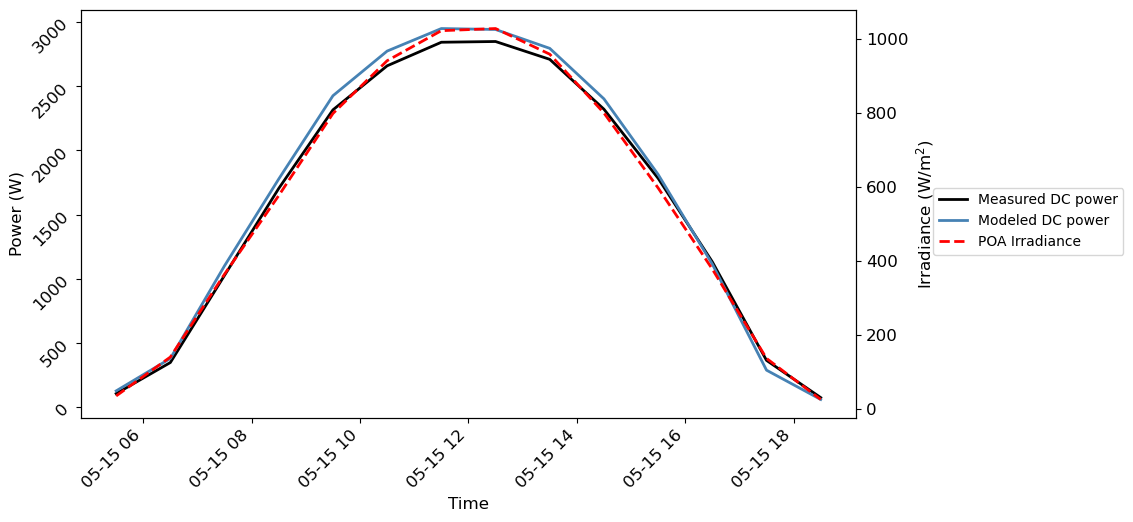

In [7]:
#diurnal plot
date = '2021-05-15'
fig, ax = plt.subplots()
ax2 = ax.twinx()
df.loc[date, 'Measured DC power (W)'].plot(ax=ax, label='Measured DC power', linewidth=2, color='black', zorder=5.5)
df.loc[date, 'Modeled DC Power'].plot(ax=ax, label='Modeled DC power', linewidth=2, color='steelblue', zorder=5.5)
df.loc[date, 'Measured front POA irradiance (W/m2)'].plot(ax=ax2, label='POA Irradiance', linewidth=2, color='red', zorder=2.5, linestyle='dashed')

line_1 = Line2D([0], [0], color='black', linewidth=2, linestyle='-',label='Measured DC power')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Modeled DC power')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='POA Irradiance')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.1, 0.4],handles=lines)
ax.set_ylabel('Power (W)')
ax.tick_params(labelrotation=45)
ax2.set_ylabel('Irradiance (W/m$^2$)')
ax.set_xlabel('Time')

## 4. Compare modeled values to measured values + other baseline models

### 3 steps of analysis:
<li><b>1. Overall NMBE, MBE, RMSE, NRMSE, and other errors of the model</b></li>
<li><b>2. Residual analysis</b></li>
<li><b>3. Comparison to baseline model</b></li>

### Analysis I: Overall errors of the model
#### • Normalized Bias Error (NBE) - shows the estimation bias of the model
###                  $100 * \frac{V_{modeled} - V_{measured}}{V_{measured}}$


#### • Root Mean Squared Error (RMSE) - measures average difference between modeled and measured values
### $ \sqrt{\frac{1}{N} \sum_{i=1}^{N}(V_{modeled}-V_{measured})^2} $

In [8]:
df['NBE'] = 100 * (df['Modeled DC Power'] - df['Measured DC power (W)'])/(df['Measured DC power (W)'])
nmbe = df['NBE'].mean()
df['BE'] = (df['Modeled DC Power'] - df['Measured DC power (W)'])
mbe = df['BE'].mean()
rmse = sklearn.metrics.mean_squared_error(df.dropna()['Modeled DC Power'],df.dropna()['Measured DC power (W)'], squared=False)
nrmse = 100 * rmse/(df['Measured DC power (W)'].mean())
#print these in a neat table 
d = [['NMBE', str(round(nmbe,3))+' %'], ['MBE', str(round(mbe,3))+' W'], ['NRMSE', str(round(nrmse,3))+' %'], ['RMSE',str(round(rmse,3))+' W']]
print (tabulate(d, headers=["Metric", "Value"]))

Metric    Value
--------  ---------
NMBE      4.613 %
MBE       70.46 W
NRMSE     6.007 %
RMSE      100.944 W


### Plotting the measured vs modeled values
The plot should be mostly linear. r and slope values close to one indicate good correlation and accurate model performance

Text(0.5, 1.0, 'Measured vs Modeled Values')

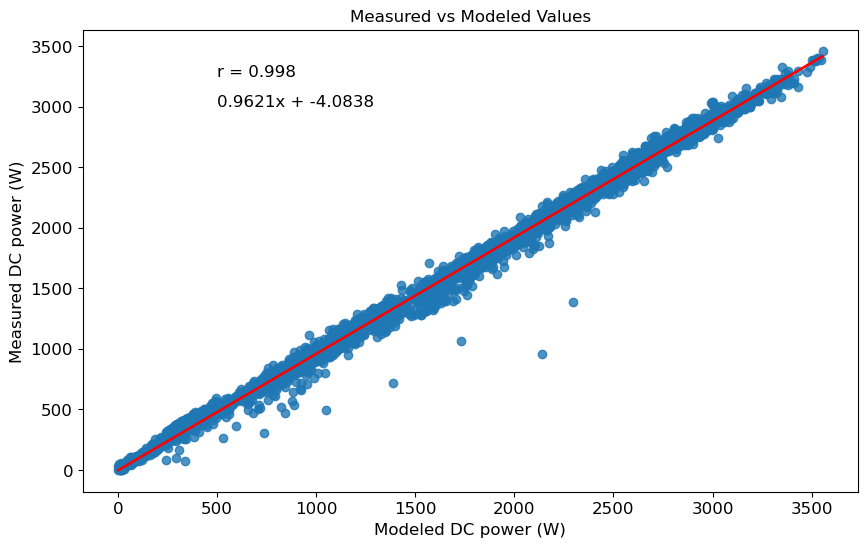

In [9]:
slope, intercept, r, p, std = scipy.stats.linregress(x = df.dropna()['Modeled DC Power'], y = df.dropna()['Measured DC power (W)'])
sns.regplot(x = df['Modeled DC Power'], y = df['Measured DC power (W)'], line_kws={'color':'red'})

plt.ylabel('Measured DC power (W)')
plt.xlabel('Modeled DC power (W)')
plt.text(500, 3250, s = ("r = "+str(round(r,4))))
plt.text(500, 3000, s = (str(round(slope,4))+'x + '+str(round(intercept,4))))
plt.title('Measured vs Modeled Values')

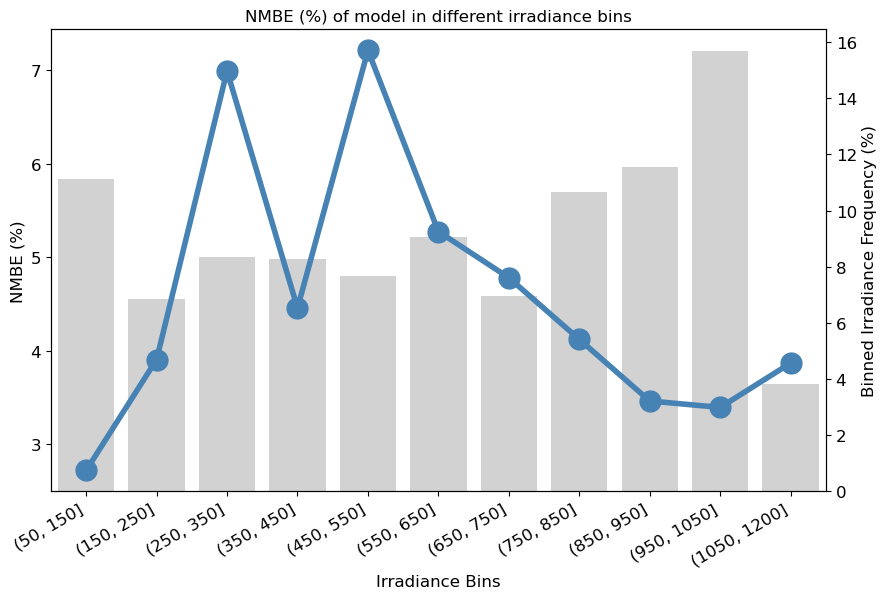

In [10]:
#plotting NMBE for each irradiance bin to see performance at different irradiance levels
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins = bins.rename(columns = {'count':'Frequency'})
bins['Irradiance Bins'] = bins.index
bins.index.names = ['Index']
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df[['Irradiance Bins','NBE']].groupby('Irradiance Bins').mean().sort_values('Irradiance Bins')['NBE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=4, markersize=15)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('NMBE (%)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plt.title('NMBE (%) of model in different irradiance bins')
plt.show()


Text(0.5, 1.0, 'NMBE (%) of the model by month')

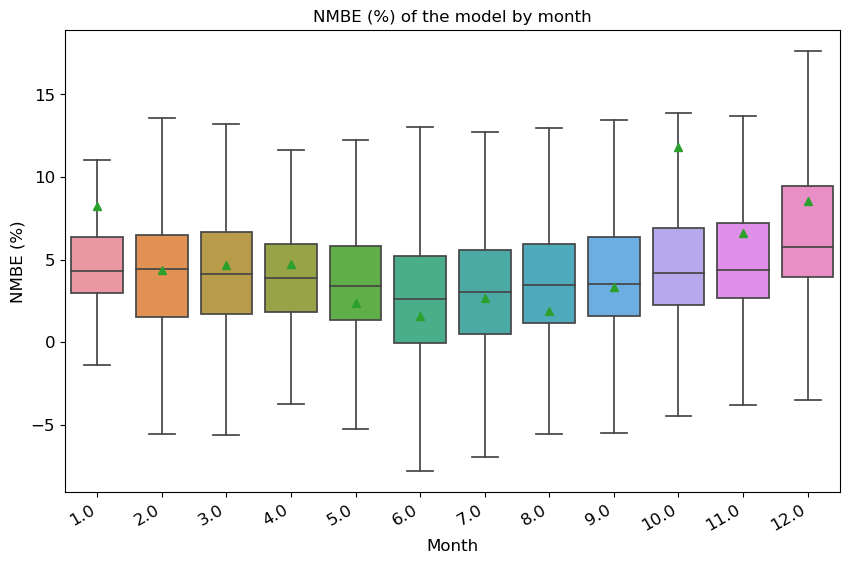

In [11]:
#nmbe by month
sns.boxplot(data=df, x='Month', y='NBE', showfliers=False, showmeans=True)
plt.xticks(rotation=30, ha='right')
plt.ylabel('NMBE (%)')
plt.title('NMBE (%) of the model by month')

### Analemma Plots
These are another way to check seasonality of a model and can also show how the model performs at specific times of day

Text(0.5, 0, 'Solar Azimuth')

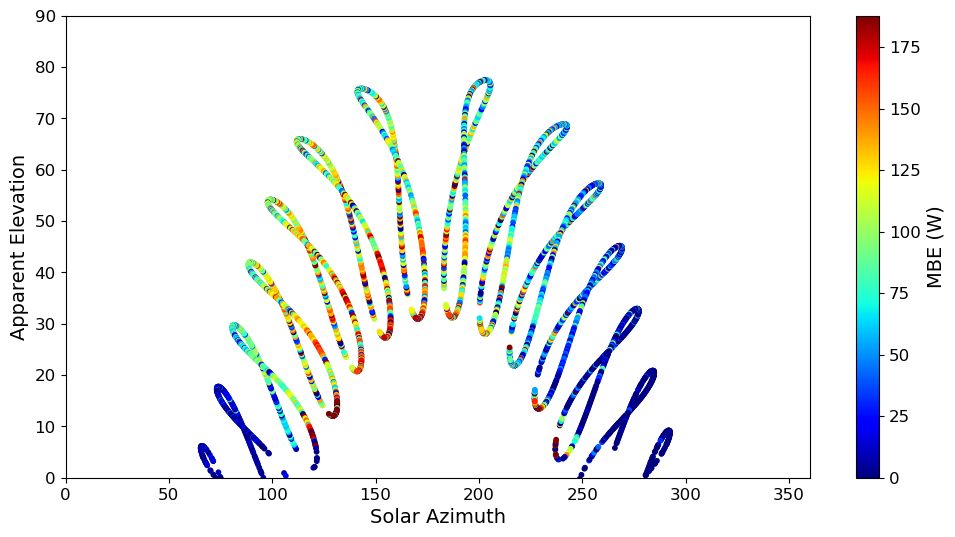

In [12]:
#analemma plots show the performance at different times of the day/year
plt.figure(figsize=(12,6))
plt.scatter(x=df['Azimuth'], y=df['Sol Elev'], c=df['BE'], cmap='jet', s=10)
clb = plt.colorbar()
clb.ax.set_ylabel('MBE (W)',fontsize =14)
plt.clim(0,(df['BE'].describe()['75%'] + df['BE'].describe()['std']))
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation', fontsize=14 )
plt.xlabel('Solar Azimuth',fontsize =14)

### Energy Yield Estimates
We can compare the energy yield estimate to the measured value to see what the difference is on an annual scale

In [13]:
ann_energy_meas = round(df['Measured DC power (W)'].sum()/1000,3)
ann_energy_model = round(df['Modeled DC Power'].sum()/1000,3)
#find overall % diff for annual energy
print('The measured annual energy is',ann_energy_meas ,
      'kWh and the predicted annual energy using the model is',ann_energy_model , 'kWh')
print('The % difference in energy estimate from measured to modeled is ', 
      round(((ann_energy_model-ann_energy_meas)/ann_energy_meas)*100,3),'%')

The measured annual energy is 6478.433 kWh and the predicted annual energy using the model is 6750.058 kWh
The % difference in energy estimate from measured to modeled is  4.193 %


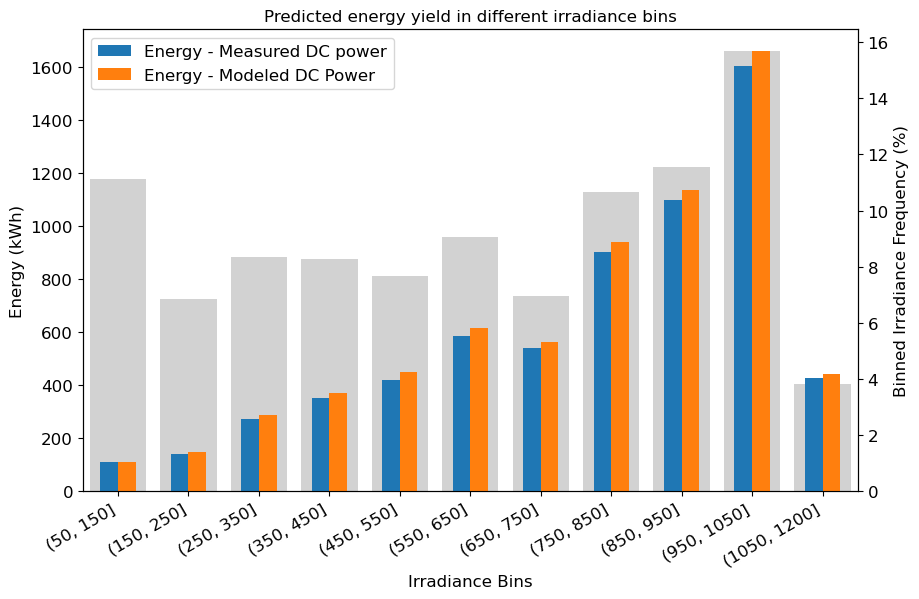

In [14]:
#we can plot the energy produced in each bin of irradiance and see where the largest differences are 

bins['Energy - Modeled DC Power'] = df.groupby('Irradiance Bins').sum()['Modeled DC Power']/1000
bins['Energy - Measured DC power'] = df.groupby('Irradiance Bins').sum()['Measured DC power (W)']/1000
bins = bins.sort_values('Irradiance Bins')

ax = bins.plot(x="Irradiance Bins", y=["Energy - Measured DC power", "Energy - Modeled DC Power"], kind="bar", rot=0)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Energy (kWh)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plt.title('Predicted energy yield in different irradiance bins')
plt.show()


### Analysis II: Residual Analysis
#### • Residual Analysis - quantifies the degree that variables may affect model errors
### $V_{modeled} - V_{measured}$

### Residual Distribution
Residuals should be normally distributed, otherwise this indicates a consistent bias of over or under predicting \
To get a closer look at a majority of the residuals, the outer 1% are removed using z-score. The distribution should be centered about the mean, shown by the red line

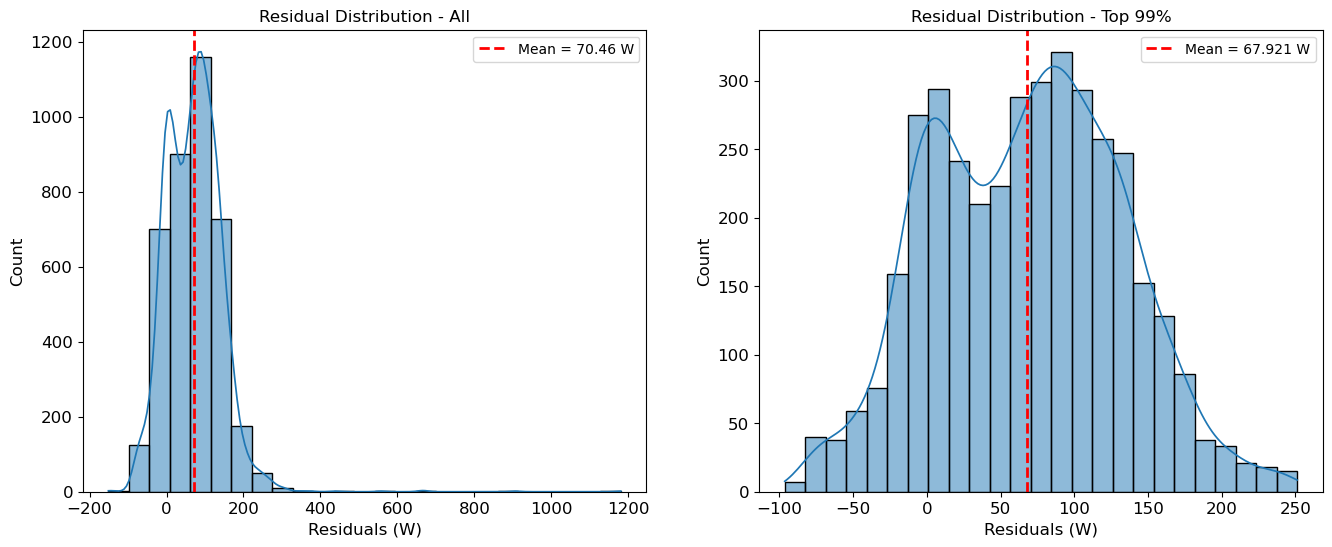

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

df['Residuals'] = df['Modeled DC Power'] - df['Measured DC power (W)']
#plot them on histogram
hsp = sns.histplot(df['Residuals'], kde=True, bins=25, ax=ax1)
#add vertical line to show mean
ax1.axvline(x=df['Residuals'].mean(), linewidth=2, color='red',linestyle='--', label =('Mean ='+' '+str(round(df['Residuals'].mean(),3))+' W'))
ax1.set_title('Residual Distribution - All')
ax1.set_xlabel('Residuals (W)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['Residuals'].mean(),3))+' W'))]
ax1.legend(prop=dict(size='small'),handles=line_4)

#Use z-score to eliminate the outer 1% of residuals
df['zscore'] = scipy.stats.zscore(df['Residuals'].dropna())
df['resid_trim'] = df['Residuals'][(df['zscore'] < 2.5) & (df['zscore'] > -2.5)]
#plot them on histogram
hsp = sns.histplot(df['resid_trim'], kde=True, bins=25, ax=ax2)
#add vertical line to show mean
ax2.axvline(x=df['resid_trim'].mean(), linewidth=2, color='red',linestyle='--',label =('Mean ='+' '+str(round(df['resid_trim'].mean(),3))+' W'))
ax2.set_title('Residual Distribution - Top 99%')
ax2.set_xlabel('Residuals (W)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['resid_trim'].mean(),3))+' W'))]
ax2.legend(prop=dict(size='small'),handles=line_4)

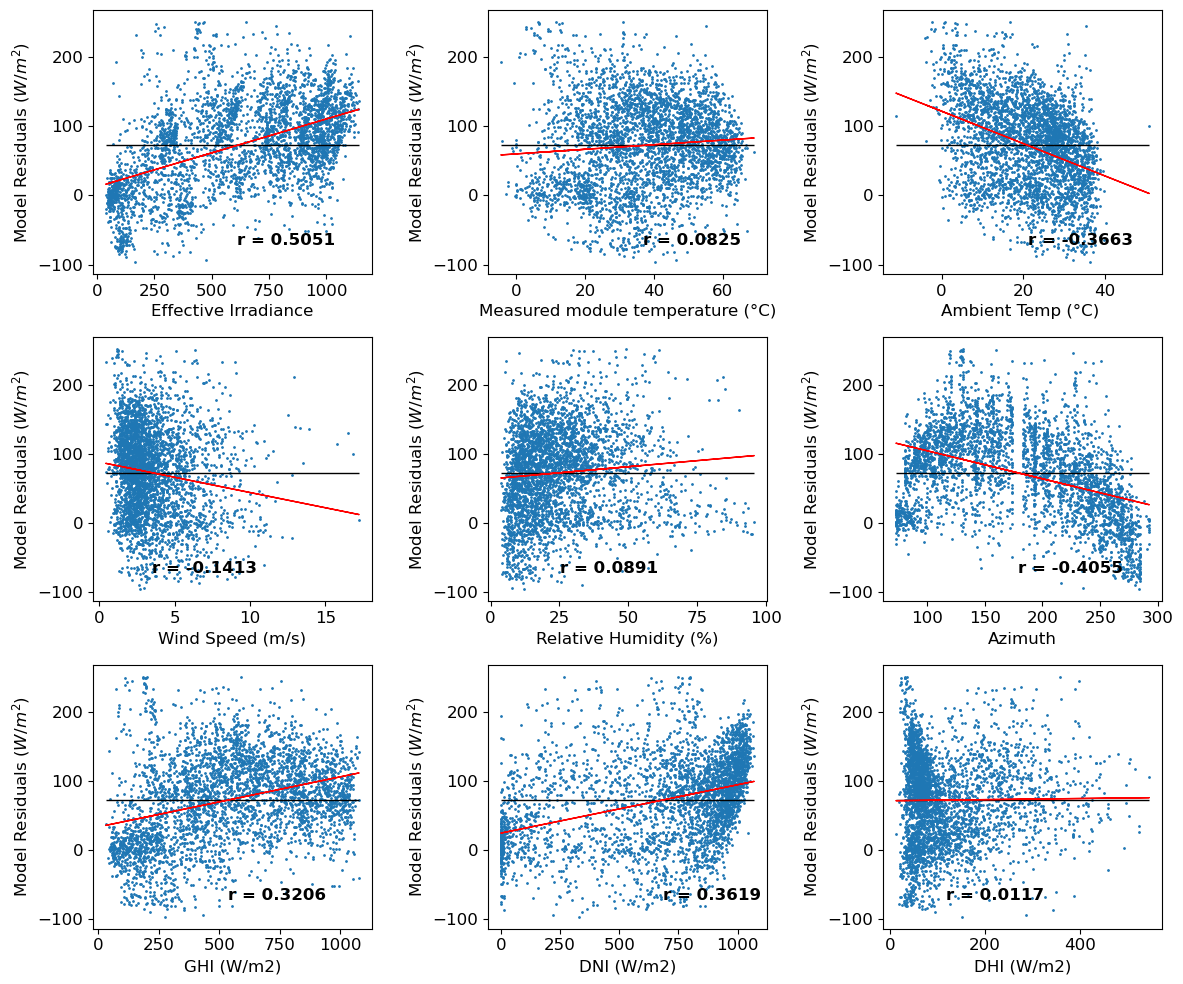

In [16]:
#plot residuals against common inputs into performance models - high correlation could indicate a weakness in the model's consideration of that variable
df = df.dropna()
covariates = ['Effective Irradiance', 'Measured module temperature (°C)', 'Ambient Temp (°C) ','Wind Speed (m/s)', 'Relative Humidity (%)', 'Azimuth','GHI (W/m2)','DNI (W/m2)', 'DHI (W/m2)']
y = df['resid_trim']
y_avg = df['resid_trim'].mean()
y_med = df['resid_trim'].median()

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for covariate, ax in zip(covariates, axes.flatten()):
    x = df[covariate]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    r = np.corrcoef(x, y)[0][1]
    
    ax.scatter(x, y, s=1)
    ax.hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black', linestyles='-')
    ax.text(x=x.mean(), y=(y.min() + (-0.25*y.min())), s=f"r = {r:0.04f}", weight='bold')
    ax.plot(x, p(x), linewidth=1, color='red')
    ax.set_xlabel(covariate)
    ax.set_ylabel('Model Residuals ($W/m^2$)')

fig.tight_layout()

## Plotting residuals vs AOI with division of some metric
Plotting the residuals vs AOI helps to describe the time of day dependence

Text(0.5, 1.0, 'Residuals of Model at High and Low Clearness Index levels')

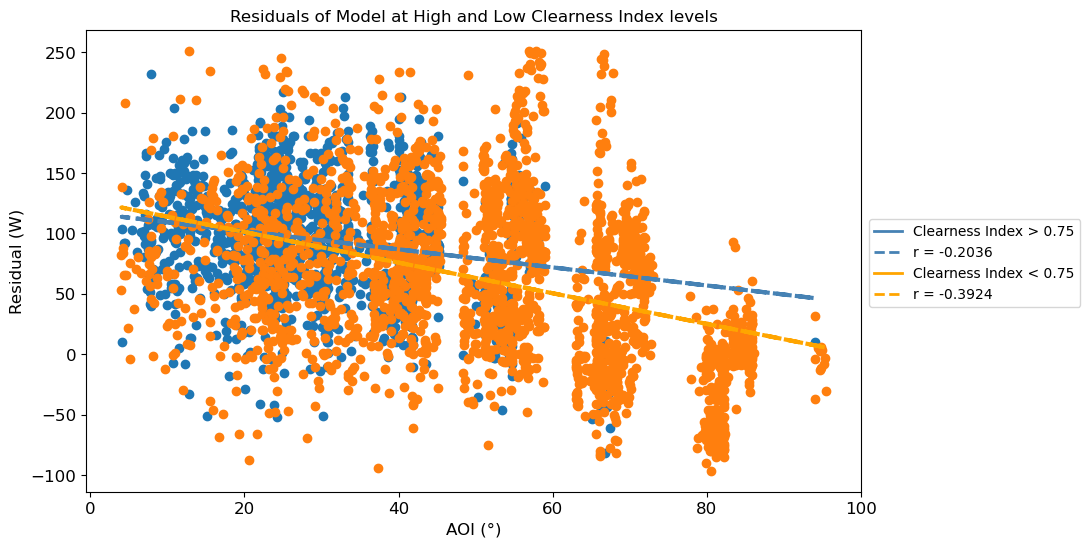

In [17]:
metric = 'Clearness Index' #<---------------- could be any value that is a column in the df (wind speed, clearness index, ambient temp)
bound = 0.75 #<------------------------------ the bound at which to separate the upper and lower categories

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

z_h = np.polyfit(df_h['AOI'],df_h['resid_trim'], 1)
p_h = np.poly1d(z_h)
r_h = np.corrcoef(x=df_h['AOI'], y=df_h['resid_trim'])[0][1]

z_l = np.polyfit(df_l['AOI'],df_l['resid_trim'], 1)
p_l = np.poly1d(z_l)
r_l = np.corrcoef(x=df_l['AOI'], y=df_l['resid_trim'])[0][1]


plt.scatter(x=df_h['AOI'], y=df_h['resid_trim'])
plt.plot(df_h['AOI'], p_h(df_h['AOI']), linewidth=3, color='steelblue',linestyle='--',)
plt.scatter(x=df_l['AOI'], y=df_l['resid_trim'])
plt.plot(df_l['AOI'], p_l(df_l['AOI']), linewidth=3, color='orange',linestyle='--')

plt.ylabel('Residual (W)')
plt.xlabel('AOI (°)')

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=(metric+' > '+str(bound)))
line_2 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='--',label=f"r = {r_h:0.04f}")
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label=(metric+' < '+str(bound)))
line_4 = Line2D([0], [0], color='orange', linewidth=2, linestyle='--',label=f"r = {r_l:0.04f}")

lines = [line_1,line_2,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('Residuals of Model at High and Low '+metric+' levels')

### Residuals by month
Grouping the residuals by month is one way to check if the model has any extreme behavior in specific seasons of the year \
This is done below with a boxplot which shows the spread of the data within the months

Text(0.5, 1.0, 'Model Residuals by Month')

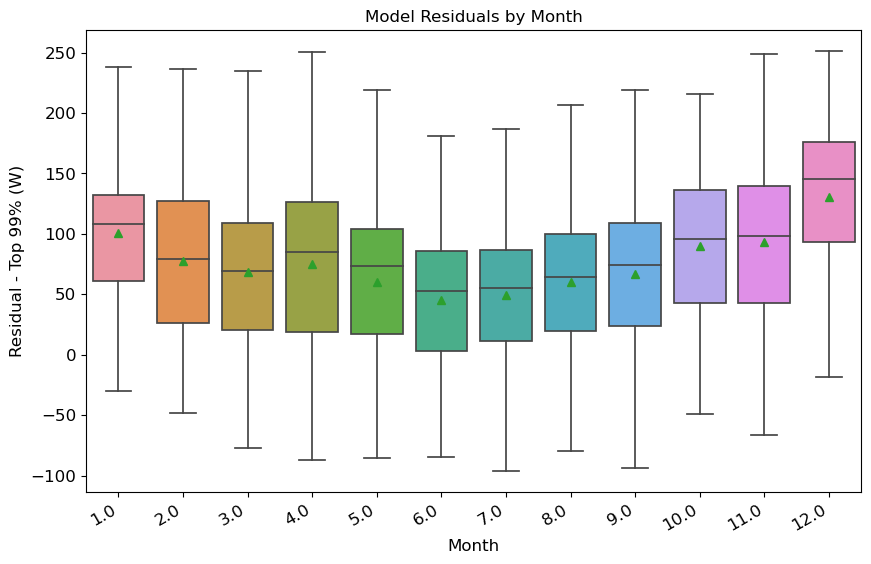

In [18]:
sns.boxplot(data=df, x='Month', y='resid_trim', showfliers=False, showmeans=True)
plt.xticks(rotation=30, ha='right')
plt.ylabel('Residual - Top 99% (W)')
plt.title('Model Residuals by Month')

### Empirical Cumulative Distribution Plot (ECDF)

Text(0.5, 1.0, 'ECDF of Model Residuals - Top 99%')

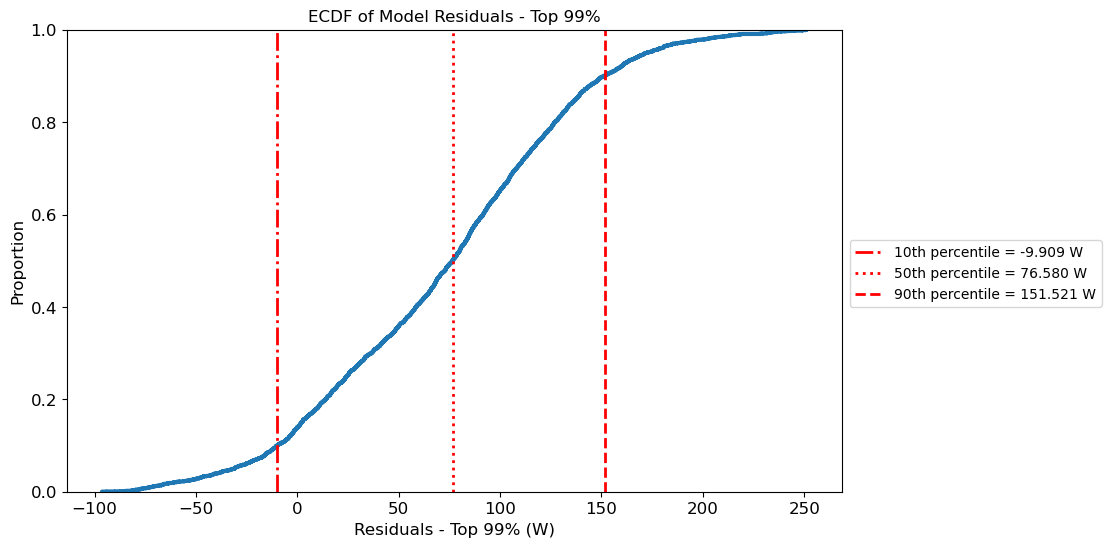

In [19]:
#plot empirical cumulative distribution functions - another way to visualize the distribution of the residuals
sns.ecdfplot(data=df, x='resid_trim', linewidth=3)
plt.xlabel('Residuals - Top 99% (W)')
perc10 = df['resid_trim'].quantile(0.1)
perc50 = df['resid_trim'].quantile(0.5)
perc90 = df['resid_trim'].quantile(0.9)
plt.axvline(perc10, linewidth=2, color='red', linestyle='-.', label=f'10th percentile = {perc10:0.03f} W')
plt.axvline(perc50, linewidth=2, color='red', linestyle='dotted', label=f'50th percentile = {perc50:0.03f} W')
plt.axvline(perc90, linewidth=2, color='red', linestyle='--', label=f'90th percentile = {perc90:0.03f} W')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.title('ECDF of Model Residuals - Top 99%')

### Relative Efficiency

####  Calculate the temperature corrected efficiency:
##  $\eta_{@ 25°C} = \frac{Power * (1 + \gamma*(25°C - T_{Module}))}{POA * Area}$

#### Then calculate the nominal efficiency by taking the median efficiency using measured module performance when irradiance is ~1000 $W/m^2$ and AOI < 70°
##### The range around 1000 $W/m^2$ can vary based on location and annual irradiance values

In [20]:
#temperature corrected efficiency
df['Eff at 25C'] = df['Modeled DC Power'] * (1 + (module['Gamma Pmp'] * (25 - (df['Measured module temperature (°C)']))))/(df['Measured front POA irradiance (W/m2)'] * module['Area'])

In [21]:
#determining nominal efficiency
#we take a window around 1000 w/m2 & use only times where AOI < 70
low_lim = 950
upp_lim = 1050
aoi_lim = 70
df_eff = df.loc[(df['Effective Irradiance'] > low_lim) & (df['Effective Irradiance'] < upp_lim) & (df['AOI'] < aoi_lim)]
eff_nom = ((df_eff['Modeled DC Power'] * (1 + (-0.0041 * (25 - (df['Measured module temperature (°C)'])))))/(df_eff['Measured front POA irradiance (W/m2)'] * module['Area'])).median()

In [22]:
#use the nominal efficiency to calculate relative efficiency
df['Relative Efficiency'] = df['Eff at 25C']/eff_nom

(0.6, 1.3)

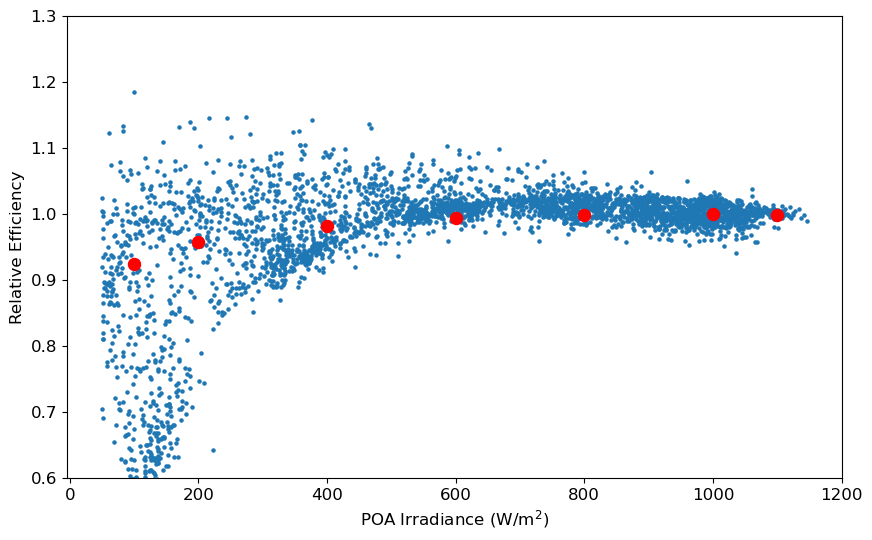

In [23]:
plt.scatter(df['Measured front POA irradiance (W/m2)'],df['Relative Efficiency'], s=5)
plt.scatter(efficiency['Irradiance'], efficiency['Relative Efficiency'], s=75, c='red')
plt.ylabel('Relative Efficiency')
plt.xlabel('POA Irradiance (W/m$^2$)')
plt.ylim(0.6,1.3)

Text(0.5, 1.0, 'ECDF of Model at High and Low Wind Speed (m/s) levels')

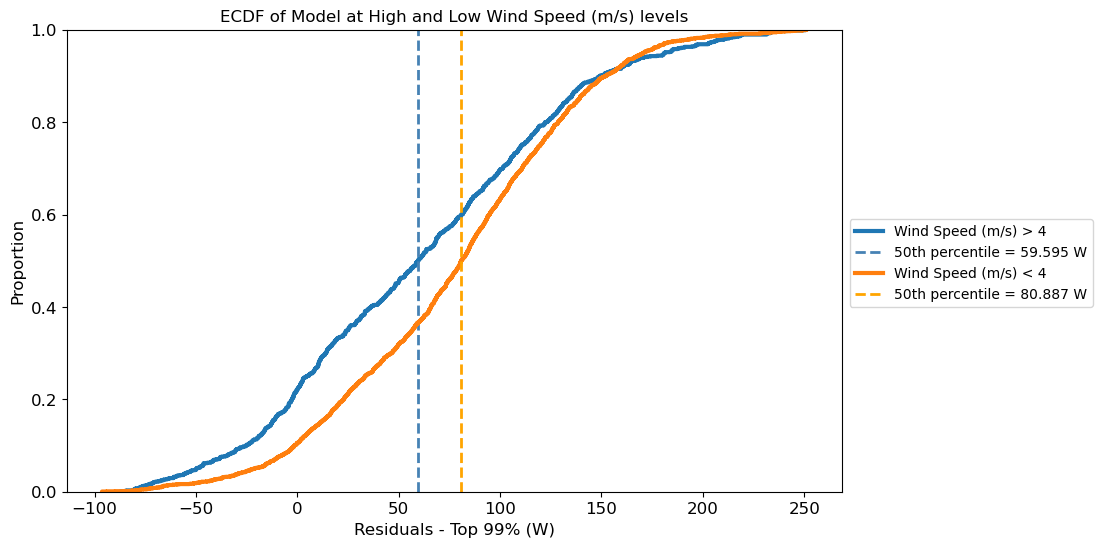

In [24]:
metric = 'Wind Speed (m/s)' #<---------------- could be any value that is a column in the df (wind speed, clearness index, ambient temp)
bound = 4 #<------------------------------ the bound at which to separate the upper and lower categories

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

perc50_h = df_h['resid_trim'].quantile(0.5)
perc50_l = df_l['resid_trim'].quantile(0.5)

sns.ecdfplot(data=df_h, x='resid_trim', linewidth=3, label=(metric+' > '+str(bound)))
plt.axvline(perc50_h, linewidth=2, color='steelblue', linestyle='--', label=f'50th percentile = {perc50_h:0.03f} W')
sns.ecdfplot(data=df_l, x='resid_trim', linewidth=3, label = (metric+' < '+str(bound)))
plt.axvline(perc50_l, linewidth=2, color='orange', linestyle='--', label=f'50th percentile = {perc50_l:0.03f} W')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.xlabel('Residuals - Top 99% (W)')
plt.title('ECDF of Model at High and Low '+metric+' levels')

### Analysis III: Comparison to Baseline Models
#### Comparing the model to other well-known baseline models can provide information about how the model is performing relative to accepted models. The baseline performance model chosen is the `pvlib.pvsystem.pvwatts_dc` model.

In [25]:
# run a baseline model with the same inputs as test model
#Run PVW and calculate string power
pvw_pdc = pvlib.pvsystem.pvwatts_dc(g_poa_effective = df['Effective Irradiance'], temp_cell = df['Cell Temperature'],pdc0 = module['Pmp'],gamma_pdc = module['Gamma Pmp'])
df['Baseline Model DC Power'] = (pvw_pdc*module['String Length'])
ann_energy_baseline =  round(df['Baseline Model DC Power'].sum()/1000,3)
#calculate some basic error metrics
df['Baseline Residuals'] = df['Baseline Model DC Power'] - df['Measured DC power (W)']
df['Baseline NBE'] = 100 * (df['Baseline Model DC Power'] - df['Measured DC power (W)'])/(df['Measured DC power (W)'])
baseline_model = 'PVWatts'

In [26]:
#find overall % diff for annual energy
print('The annual energy yield predicted by the initial model is', ann_energy_model,
      'kWh and the predicted annual energy using the baseline model is',ann_energy_baseline, 'kWh')
print('The % difference in energy estimate when using the initial vs baseline model is ', 
      round(((ann_energy_baseline-ann_energy_model)/ann_energy_model)*100,3),'%')

The annual energy yield predicted by the initial model is 6750.058 kWh and the predicted annual energy using the baseline model is 6622.547 kWh
The % difference in energy estimate when using the initial vs baseline model is  -1.889 %


Text(0.5, 1.0, 'Residuals for Model & Baseline Model')

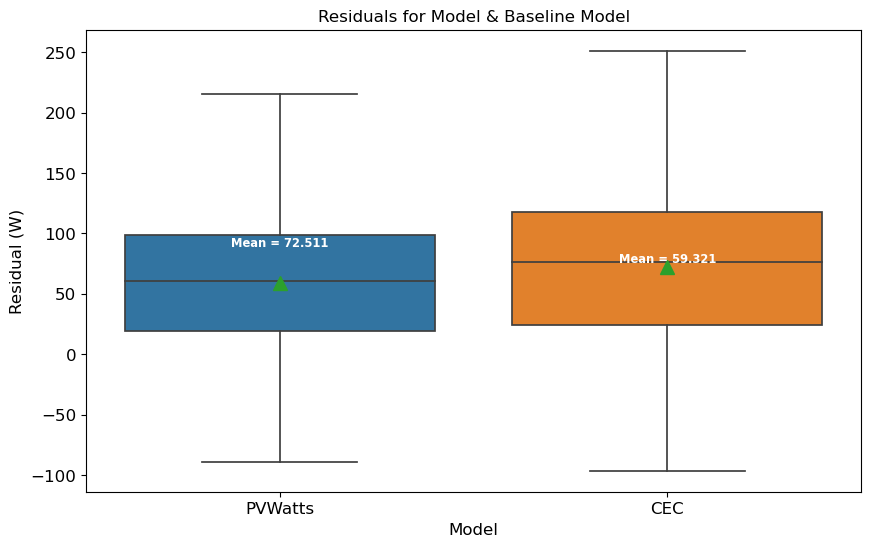

In [27]:
#put the model and baseline model residuals in one df for easy analysis
resid_df = pd.concat([
    pd.DataFrame({'Residual': df['Baseline Model DC Power'] - df['Measured DC power (W)'], 'Model': baseline_model,}),
    pd.DataFrame({'Residual': df['Modeled DC Power'] - df['Measured DC power (W)'],'Model':model_name ,})
], ignore_index=True)

box_plot = sns.boxplot(x='Model', y='Residual', data=resid_df, showfliers=False, showmeans=True, meanprops={'markersize':10})
plt.ylabel('Residual (W)')
#view the numerical value of mean on plot
means = resid_df.groupby(['Model'])['Residual'].mean()
vertical_offset = resid_df['Residual'].mean() * 0.25 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,means[xtick] + vertical_offset,('Mean = '+str(round(means[xtick],3))),horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.title('Residuals for Model & Baseline Model')

Text(0.5, 1.0, 'ECDF of Model & Baseline Model Residuals')

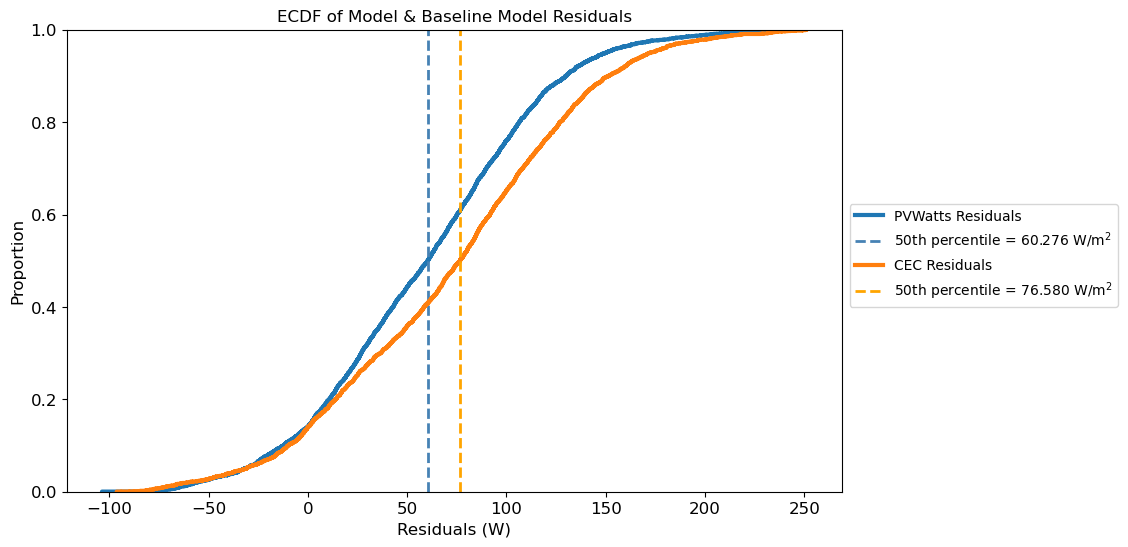

In [28]:
#ecdf of the two models overlayed & p50 for each

perc50_m = np.percentile(df['Residuals'].dropna(), 50)
perc50_b = np.percentile(df['Baseline Residuals'].dropna(), 50)

sns.ecdfplot(data=df, x='Baseline Residuals', linewidth=3, label = (baseline_model+' Residuals'))
plt.axvline(x=perc50_b, linewidth=2, color='steelblue', linestyle='--', label=f'50th percentile = {perc50_b:0.03f} W/m$^2$')
sns.ecdfplot(data=df, x='Residuals', linewidth=3, label=(model_name+' Residuals'))
plt.axvline(x=perc50_m, linewidth=2, color='orange', linestyle='--', label=f'50th percentile = {perc50_m:0.03f} W/m$^2$')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.xlabel('Residuals (W)')
plt.title('ECDF of Model & Baseline Model Residuals')

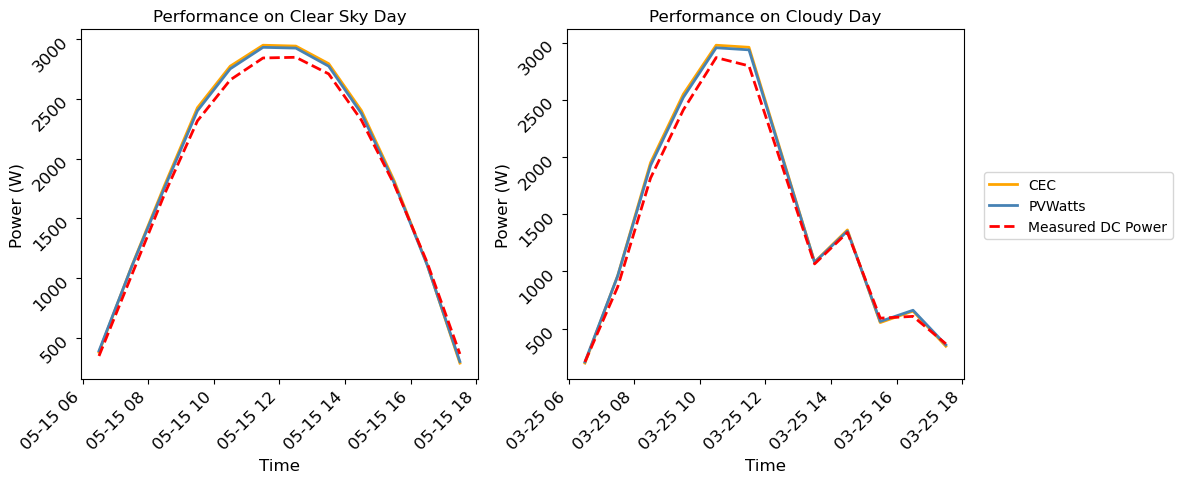

In [29]:
# diurnal plots help visualize the differences between modeled and measured power as well as between the model and baseline performance model 

dates = [('Clear Sky', '2021-05-15'),('Cloudy', '2021-03-25'),]

fig, axes = plt.subplots(1, len(dates), figsize=(12,5))

for (sky_condition, date), ax in zip(dates, axes):
    df.loc[date, 'Modeled DC Power'].plot(ax=ax, linewidth=2, color='orange', label = model_name)
    df.loc[date, 'Baseline Model DC Power'].plot(ax=ax, linewidth=2, color='steelblue',label = baseline_model)
    df.loc[date, 'Measured DC power (W)'].plot(ax=ax, linewidth=2, linestyle='dashed', color='red', label = 'Measured DC Power')
    ax.tick_params(labelrotation = 45)
    ax.set_ylabel('Power (W)')
    ax.set_xlabel('Time')
    ax.set_title(f'Performance on {sky_condition} Day')

axes[-1].legend(prop=dict(size='small'), loc=[1.05, 0.4])
fig.tight_layout()

Text(0.5, 1.0, 'NMBE (%) of models in different irradiance bins')

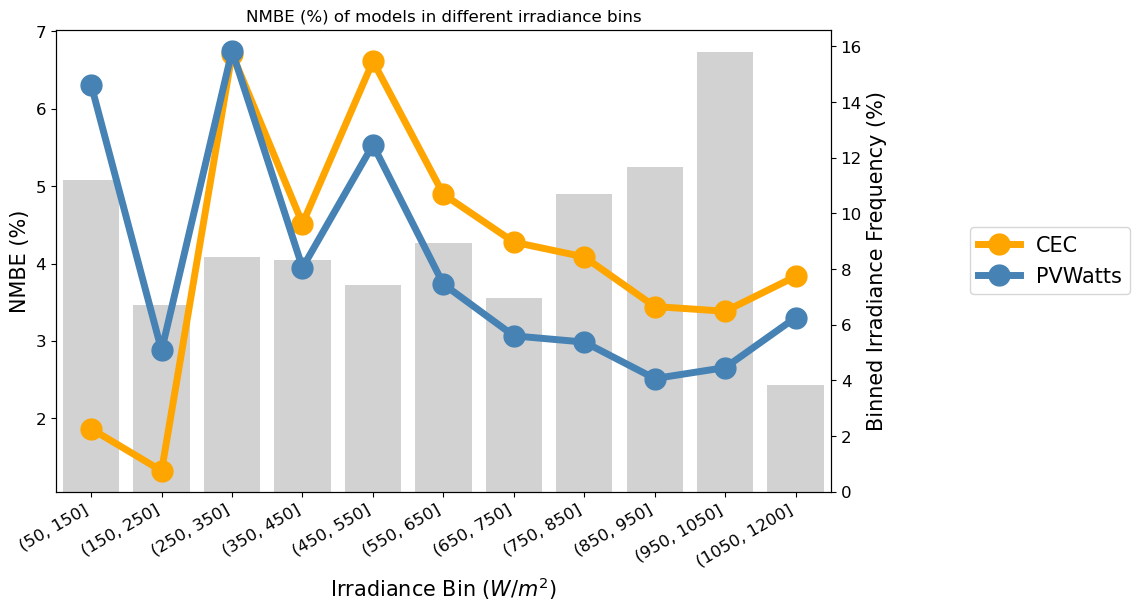

In [30]:
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'count' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df[['Irradiance Bins','NBE']].groupby('Irradiance Bins').mean()['NBE']
ax.plot(x, y, 'orange', marker='o', zorder=6.5, linewidth=5, markersize=15)
y = df[['Irradiance Bins','Baseline NBE']].groupby('Irradiance Bins').mean()['Baseline NBE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=5, markersize=15)
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('NMBE (%)', fontsize=15)
ax.set_xlabel('Irradiance Bin ($W/m^2$)', fontsize=15)
#ax.set_title(system+ ' System')
ax.legend([model_name,baseline_model],loc='center right',bbox_to_anchor=(1.4, 0.5), fontsize=15)
#ax.set_ylim(-5,10)


ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
plt.title('NMBE (%) of models in different irradiance bins')